# Training

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
# Suppress all warnings
warnings.simplefilter("ignore")

In [2]:
def count_moves(row, counts, index):
    total_moves = 0
    for i in range(1, 2564):
        move = row["Move "+ str(i)]
        # count the number of s's
        if move == 's':
            counts[10][index] += 1
        # count the number of Base's
        elif move == 'Base':
            counts[11][index] += 1
        # count the number of SingleMineral's
        elif move == 'SingleMineral':
            counts[12][index] += 1
        # count the hotkeys
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[j][index] += 1

        total_moves += 1  
    # Save the total moves count
    counts[13][index] = total_moves


def count_move_per_time(row, counts, row_index, time_interval, ti_index):
    base_index = ti_index * 14
    total_moves = 0

    for i in range(1, 2564):
        move = row["Move " + str(i)]

        # Count actions for the given time interval
        if move == 's':
            counts[base_index + 10][row_index] += 1
        elif move == 'Base':
            counts[base_index + 11][row_index] += 1
        elif move == 'SingleMineral':
            counts[base_index + 12][row_index] += 1
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[base_index + j][row_index] += 1

        total_moves += 1

        # Continue counting actions after the specified time interval
        if move == f't{time_interval}':
            break

    counts[base_index + 13][row_index] = total_moves


def mapRaces(races, row_index):
    race = train_data['Race'][row_index]

    if race == "Protoss":
        races[0][row_index] = 1
    elif race == "Terran":
        races[1][row_index] = 1
    elif race == "Zerg":
        races[2][row_index] = 1

In [3]:
# Load the training dataset
train_data = pd.read_csv('train_data.csv', delimiter=';')

# Drop unnecessary columns
train_data = train_data.drop(['PlayerURL', 'PlayerName'], axis=1)

# Create new table that only contains the first column (PlayerId) of train_data
# Keep only the first column but all rows
train_data_new = train_data.iloc[:, :1]


# Specify the target time intervals
#time_intervals = [20, 60, 100, 200]
time_intervals = [5, 20, 60, 100, 200, 270, 340, 550]

calc_column = len(time_intervals)* 14 + 14

# New lists of counts
counts = [[0] * 3052 for _ in range(calc_column)]
# New lists of races
races = [[0] * 3052 for _ in range(3)]


# Go through the rows using the functions to count the actions, map the races
for row_index, row in train_data.iterrows():
    count_moves(row, counts, row_index)
    mapRaces(races, row_index)

    for ti_index, time_interval in enumerate(time_intervals):
        count_move_per_time(row, counts, row_index, time_interval, ti_index+1)
        

for i in range(calc_column):
    locals()[f'count_{i}'] = counts[i]

for i in range(10):
    train_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]

train_data_new['sFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[10])]
train_data_new['baseFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[11])]
train_data_new['singleMineralFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[12])]

# Adding new columns for the count of moves per interval
for ti_index, time_interval in enumerate(time_intervals):
    base_index = (ti_index + 1) * 14
    for j in range(10):
        column_name = f'hk{j}_t{time_interval}_Frequency'
        train_data_new[column_name] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + j])]

    train_data_new[f's_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 10])]
    train_data_new[f'base_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 11])]
    train_data_new[f'singleMineral_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 12])]


# Adding new columns for the races
train_data_new['race_Protoss'] = races[0]
train_data_new['race_Terran'] = races[1]
train_data_new['race_Zerg'] = races[2]

# Saving them in a csv file
train_data_new.to_csv('actiontype_count.csv', index=False)

train_data_new.head()

,PlayerID,hk0Frequency,hk1Frequency,hk2Frequency,hk3Frequency,hk4Frequency,hk5Frequency,hk6Frequency,hk7Frequency,hk8Frequency,...,hk6_t550_Frequency,hk7_t550_Frequency,hk8_t550_Frequency,hk9_t550_Frequency,s_t550_Frequency,base_t550_Frequency,singleMineral_t550_Frequency,race_Protoss,race_Terran,race_Zerg
0,1021189,0.0,0.158018,0.107296,0.032384,0.030043,0.007803,0.000390,0.00000,0.0,...,0.000994,0.000000,0.0,0.0,0.407555,0.0,0.000994,0,1,0
1,1021189,0.0,0.149044,0.062037,0.055014,0.017167,0.001951,0.000390,0.00000,0.0,...,0.000853,0.000000,0.0,0.0,0.320546,0.0,0.000000,0,1,0
2,1021189,0.0,0.130316,0.086617,0.018728,0.030823,0.006243,0.000390,0.00039,0.0,...,0.001289,0.001289,0.0,0.0,0.389175,0.0,0.002577,0,1,0
3,1021189,0.0,0.166602,0.120562,0.033554,0.044479,0.021459,0.001171,0.00000,0.0,...,0.000971,0.000000,0.0,0.0,0.350485,0.0,0.000971,0,1,0
4,1021189,0.0,0.154506,0.077253,0.022630,0.041748,0.010925,0.000390,0.00039,0.0,...,0.001104,0.001104,0.0,0.0,0.429360,0.0,0.002208,0,1,0


In [4]:
# Target
labels = train_data_new['PlayerID']

# Keep only the columns we need as features
features = train_data_new.drop(['PlayerID'], axis=1)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Choose a model (e.g., Decision Tree) and train it
model = RandomForestClassifier(random_state=42, n_estimators=200)

# Hyperparameter tuning using GridSearchCV
param_grid = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(model, param_grid, cv=4)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_model, 'player_id_prediction_model.pkl')

# Use the best model for predictions
predictions = best_model.predict(X_val)

print(f1_score(y_val, predictions, average='micro'))

# Use the best model for cross-validation scores
scores = cross_val_score(best_model, features, labels, cv=4)
print(scores)

# Evaluation of the model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

0.9263502454991817
[0.90432503 0.92529489 0.92529489 0.92267366]
Accuracy: 0.9263502454991817


## Feature Importance for Training

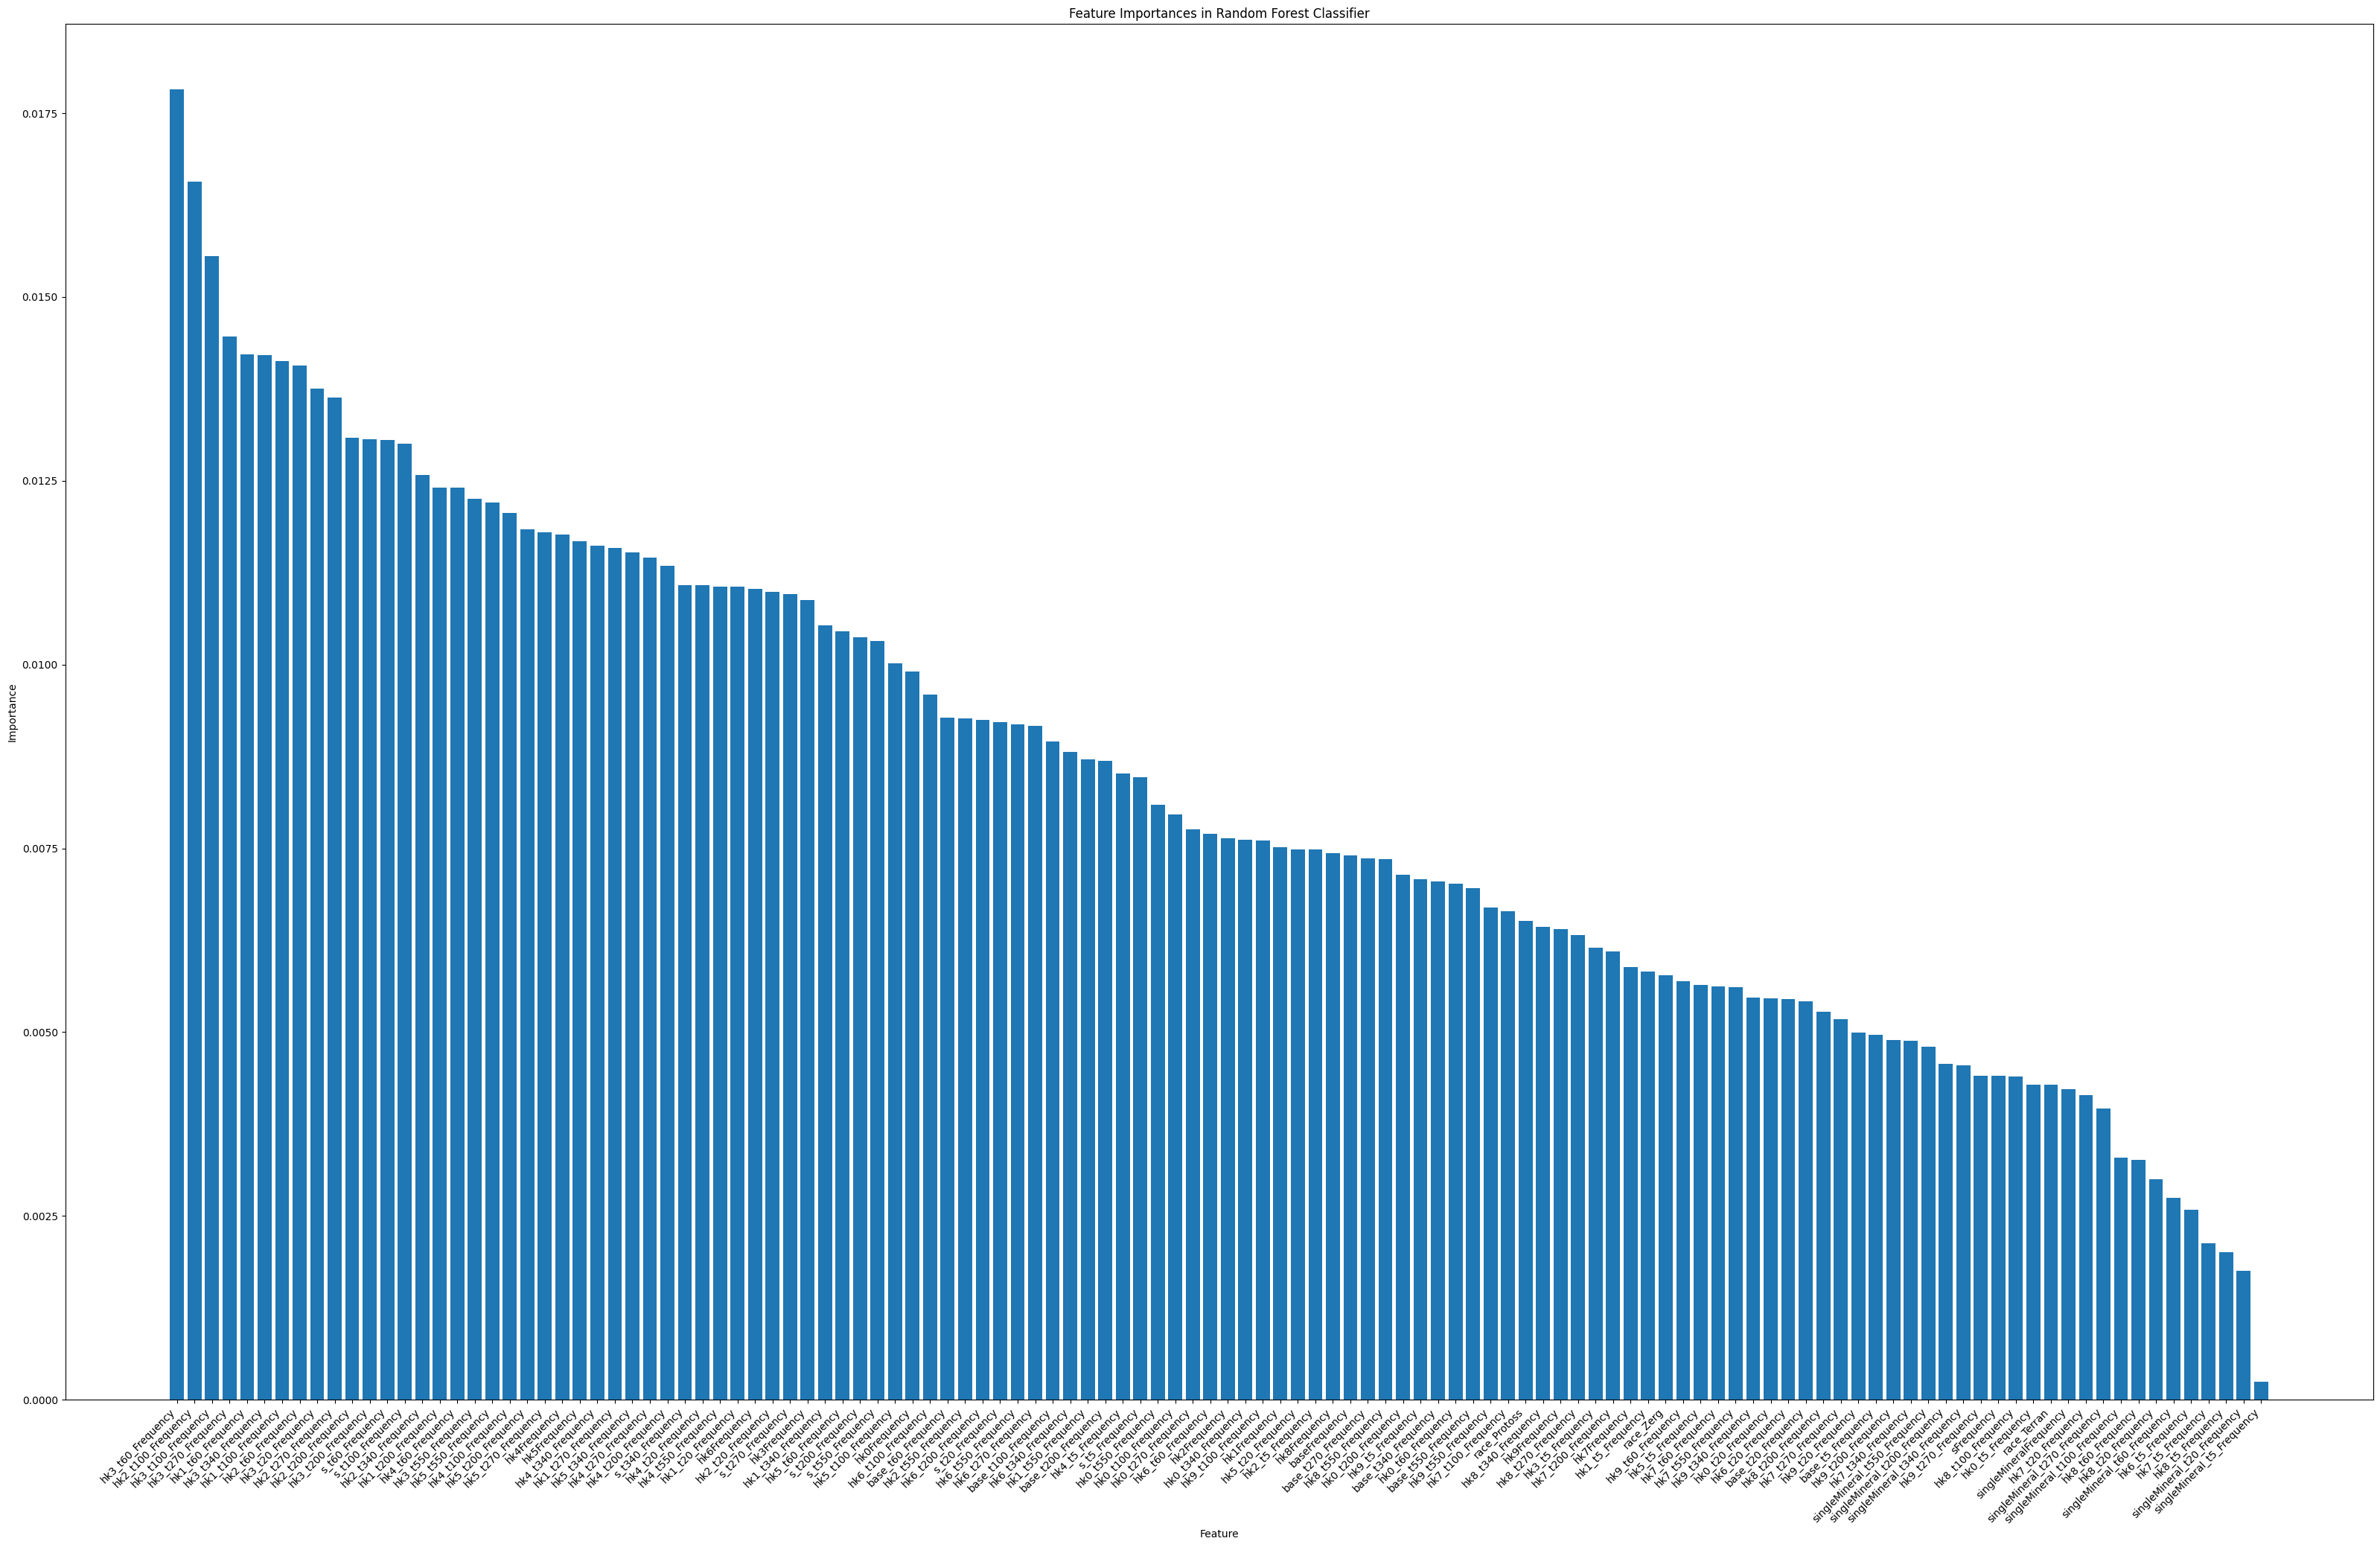

In [5]:
# Explore feature importances
feature_importances = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Sort features by their importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(40, 24))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[sorted_idx], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances in Random Forest Classifier")
plt.show()

# Testing

In [6]:
#same preprocessing as in train_def so that we have save structured data
def count_moves(row, counts, index):
    total_moves = 0
    for i in range(1, 3446):
        move = row["Move_"+ str(i)]

        # count the number of s's
        if move == 's':
            counts[10][index] += 1
        # count the number of Base's
        elif move == 'Base':
            counts[11][index] += 1
        # count the number of SingleMineral's
        elif move == 'SingleMineral':
            counts[12][index] += 1
        # count the hotkeys
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[j][index] += 1
        total_moves += 1  
    # Save the total moves count
    counts[13][index] = total_moves


def count_move_per_time(row, counts, row_index, time_interval, ti_index):
    base_index = ti_index*14
    total_moves = 0
    for i in range(1, 3446):
        move = row["Move_" + str(i)]

        # Count actions for the given time interval
        if move == 's':
            counts[base_index + 10][row_index] += 1
        elif move == 'Base':
            counts[base_index + 11][row_index] += 1
        elif move == 'SingleMineral':
            counts[base_index + 12][row_index] += 1
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[base_index + j][row_index] += 1

        total_moves += 1

        # Continue counting actions after the specified time interval
        if move == f't{time_interval}':
            break

    counts[base_index + 13][row_index] = total_moves


def mapRaces(races, row_index):
    race = test_data['Race'][row_index]

    if race == "Protoss":
        races[0][row_index] = 1
    elif race == "Terran":
        races[1][row_index] = 1
    elif race == "Zerg":
        races[2][row_index] = 1

In [7]:
# Load new data file 
test_data = pd.read_csv('test_data.csv', delimiter=';')
test_data.columns = ['Race'] + [f'Move_{i}' for i in range(1, 3446)]


# Create new table that only contains the first column (Race) of train_data
# Keep only the first column but all rows
test_data_new = test_data.iloc[:, :1]

# Specify the target time intervals
#time_intervals = [20, 60, 100, 200]
time_intervals = [5, 20, 60, 100, 200, 270, 340, 550]

calc_column = len(time_intervals)* 14 + 14
# New lists of counts
counts = [[0] * 340 for _ in range(calc_column)]
# New lists of races
races = [[0] * 340 for _ in range(3)]


In [8]:
# Go through the rows using the functions to count the actions, map the races
for row_index, row in test_data.iterrows():
    count_moves(row, counts, row_index)
    mapRaces(races, row_index)

    for ti_index, time_interval in enumerate(time_intervals):
        count_move_per_time(row, counts, row_index, time_interval, ti_index+1)

# Adding all the new columns to the train_data_new
# Adding new columns for the count of moves
for i in range(calc_column):
    locals()[f'count_{i}'] = counts[i]

for i in range(10):
    test_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]

test_data_new['sFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[10])]
test_data_new['baseFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[11])]
test_data_new['singleMineralFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[12])]

# Adding new columns for the count of moves per interval
for ti_index, time_interval in enumerate(time_intervals):
    base_index = (ti_index + 1) * 14
    for j in range(10):
        column_name = f'hk{j}_t{time_interval}_Frequency'
        test_data_new[column_name] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + j])]

    test_data_new[f's_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 10])]
    test_data_new[f'base_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 11])]
    test_data_new[f'singleMineral_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 12])]



# Adding new columns for the races
test_data_new['race_Protoss'] = races[0]
test_data_new['race_Terran'] = races[1]
test_data_new['race_Zerg'] = races[2]


# Saving thhem in a csv file
test_data_new.to_csv('actiontype_count_test.csv', index=False)

test_data_new.head()

,Race,hk0Frequency,hk1Frequency,hk2Frequency,hk3Frequency,hk4Frequency,hk5Frequency,hk6Frequency,hk7Frequency,hk8Frequency,...,hk6_t550_Frequency,hk7_t550_Frequency,hk8_t550_Frequency,hk9_t550_Frequency,s_t550_Frequency,base_t550_Frequency,singleMineral_t550_Frequency,race_Protoss,race_Terran,race_Zerg
0,Zerg,0.249927,0.113208,0.022351,0.001451,0.000000,0.000000,0.285922,0.013643,0.000000,...,0.322067,0.015451,0.000000,0.010623,0.201352,0.008209,0.001449,0,0,1
1,Terran,0.010160,0.101597,0.052540,0.135849,0.117562,0.045864,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.012234,0.205409,0.000000,0.000000,0,1,0
2,Protoss,0.000290,0.128882,0.178520,0.084180,0.063570,0.000000,0.305660,0.009289,0.014224,...,0.356610,0.005330,0.014392,0.000000,0.139126,0.002132,0.000000,1,0,0
3,Zerg,0.000000,0.197968,0.042961,0.010450,0.154427,0.001451,0.001161,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.378223,0.010506,0.000955,0,0,1
4,Protoss,0.000871,0.024673,0.011030,0.007837,0.008418,0.024383,0.000000,0.001161,0.001451,...,0.000000,0.005319,0.008865,0.000000,0.345745,0.035461,0.000000,1,0,0


In [9]:
# Load the pre-trained model
model_filename = 'player_id_prediction_model.pkl'
clf = joblib.load(model_filename)

features = test_data_new.drop(['Race'], axis=1)


# Use the loaded model to make predictions
predictions = clf.predict(features)

# Add predictions to the test_data_new DataFrame
test_data_new['Predicted_PlayerID'] = predictions

test_data_new.head()

,Race,hk0Frequency,hk1Frequency,hk2Frequency,hk3Frequency,hk4Frequency,hk5Frequency,hk6Frequency,hk7Frequency,hk8Frequency,...,hk7_t550_Frequency,hk8_t550_Frequency,hk9_t550_Frequency,s_t550_Frequency,base_t550_Frequency,singleMineral_t550_Frequency,race_Protoss,race_Terran,race_Zerg,Predicted_PlayerID
0,Zerg,0.249927,0.113208,0.022351,0.001451,0.000000,0.000000,0.285922,0.013643,0.000000,...,0.015451,0.000000,0.010623,0.201352,0.008209,0.001449,0,0,1,3538115
1,Terran,0.010160,0.101597,0.052540,0.135849,0.117562,0.045864,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.012234,0.205409,0.000000,0.000000,0,1,0,2896854
2,Protoss,0.000290,0.128882,0.178520,0.084180,0.063570,0.000000,0.305660,0.009289,0.014224,...,0.005330,0.014392,0.000000,0.139126,0.002132,0.000000,1,0,0,3973341
3,Zerg,0.000000,0.197968,0.042961,0.010450,0.154427,0.001451,0.001161,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.378223,0.010506,0.000955,0,0,1,250458
4,Protoss,0.000871,0.024673,0.011030,0.007837,0.008418,0.024383,0.000000,0.001161,0.001451,...,0.005319,0.008865,0.000000,0.345745,0.035461,0.000000,1,0,0,950504


In [10]:
# Load the training dataset
train_data = pd.read_csv('train_data.csv', delimiter=';')

# Extract 'PlayerID' and 'PlayerURL' columns
player = train_data[['PlayerID', 'PlayerURL']]

# take only one URL per each PlayerID
player_info = player.drop_duplicates(subset='PlayerID', keep='first')

print(player_info)

# Save the result to CSV
player_info.to_csv('player_info.csv', index=False)

      PlayerID                                          PlayerURL
0      1021189  http://eu.battle.net/sc2/en/profile/1021189/1/...
20     1058669  http://eu.battle.net/sc2/en/profile/1058669/1/...
42     1139573  http://eu.battle.net/sc2/en/profile/1139573/1/...
67     1143713  http://eu.battle.net/sc2/en/profile/1143713/1/...
82     1173786  http://eu.battle.net/sc2/en/profile/1173786/1/...
...        ...                                                ...
2988       408    http://xx.battle.net/sc2/en/profile/408/1/Polt/
2994       410  http://xx.battle.net/sc2/en/profile/410/1/STBo...
3009       413    http://xx.battle.net/sc2/en/profile/413/1/Maru/
3024       414  http://xx.battle.net/sc2/en/profile/414/1/ducK...
3033       415    http://xx.battle.net/sc2/en/profile/415/1/EGJD/

[191 rows x 2 columns]


In [11]:
# Additional statistics if needed
# For example, you can print the count of each predicted class
print("Count of Predicted PlayerIDs:")
print(test_data_new['Predicted_PlayerID'].value_counts())

# Extract 'Predicted_PlayerID' column
player_id_column = test_data_new[['Predicted_PlayerID']]

print(player_id_column)

Count of Predicted PlayerIDs:
Predicted_PlayerID
2341467    6
2342419    6
2348639    6
2332264    5
2343531    5
          ..
349650     1
1173786    1
1430346    1
3368730    1
405        1
Name: count, Length: 170, dtype: int64
     Predicted_PlayerID
0               3538115
1               2896854
2               3973341
3                250458
4                950504
..                  ...
335                 413
336                 402
337                 410
338                 405
339                 410

[340 rows x 1 columns]


In [12]:
# Extract 'Predicted_PlayerID' column
player_id_column = test_data_new[['Predicted_PlayerID']]

print(player_id_column)

# Merge the predicted ID to get the url of the player
result = pd.merge(player_id_column, player_info, left_on='Predicted_PlayerID', right_on='PlayerID', how='left')

# take only the url for each player
result = result.drop(['Predicted_PlayerID', 'PlayerID'], axis=1)
# insert a new row in position 0 as asked for the submission and count the number of lines
result.insert(0,"RowId", range(1, len(result) + 1))

print(result)

     Predicted_PlayerID
0               3538115
1               2896854
2               3973341
3                250458
4                950504
..                  ...
335                 413
336                 402
337                 410
338                 405
339                 410

[340 rows x 1 columns]
     RowId                                          PlayerURL
0        1  http://eu.battle.net/sc2/en/profile/3538115/1/...
1        2  http://eu.battle.net/sc2/en/profile/2896854/1/...
2        3  http://eu.battle.net/sc2/en/profile/3973341/1/...
3        4  http://eu.battle.net/sc2/en/profile/250458/1/V...
4        5  http://eu.battle.net/sc2/en/profile/950504/1/G...
..     ...                                                ...
335    336    http://xx.battle.net/sc2/en/profile/413/1/Maru/
336    337    http://xx.battle.net/sc2/en/profile/402/1/Dear/
337    338  http://xx.battle.net/sc2/en/profile/410/1/STBo...
338    339     http://xx.battle.net/sc2/en/profile/405/1/MMA/
339   

In [13]:
# Save 'PlayerURL' to CSV
result.to_csv('player_id_only.csv', index=False)


# Print additional statistics or analysis if needed
print("Count of Unique PlayerURLs:")
print(result['PlayerURL'].nunique())

Count of Unique PlayerURLs:
170


In [14]:
# Load the first row of the features DataFrame
first_row_features = features.iloc[[0]]

# Use the loaded model to get the feature importances for the first prediction
feature_importances = clf.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': first_row_features.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

## Feature Importance for Testing

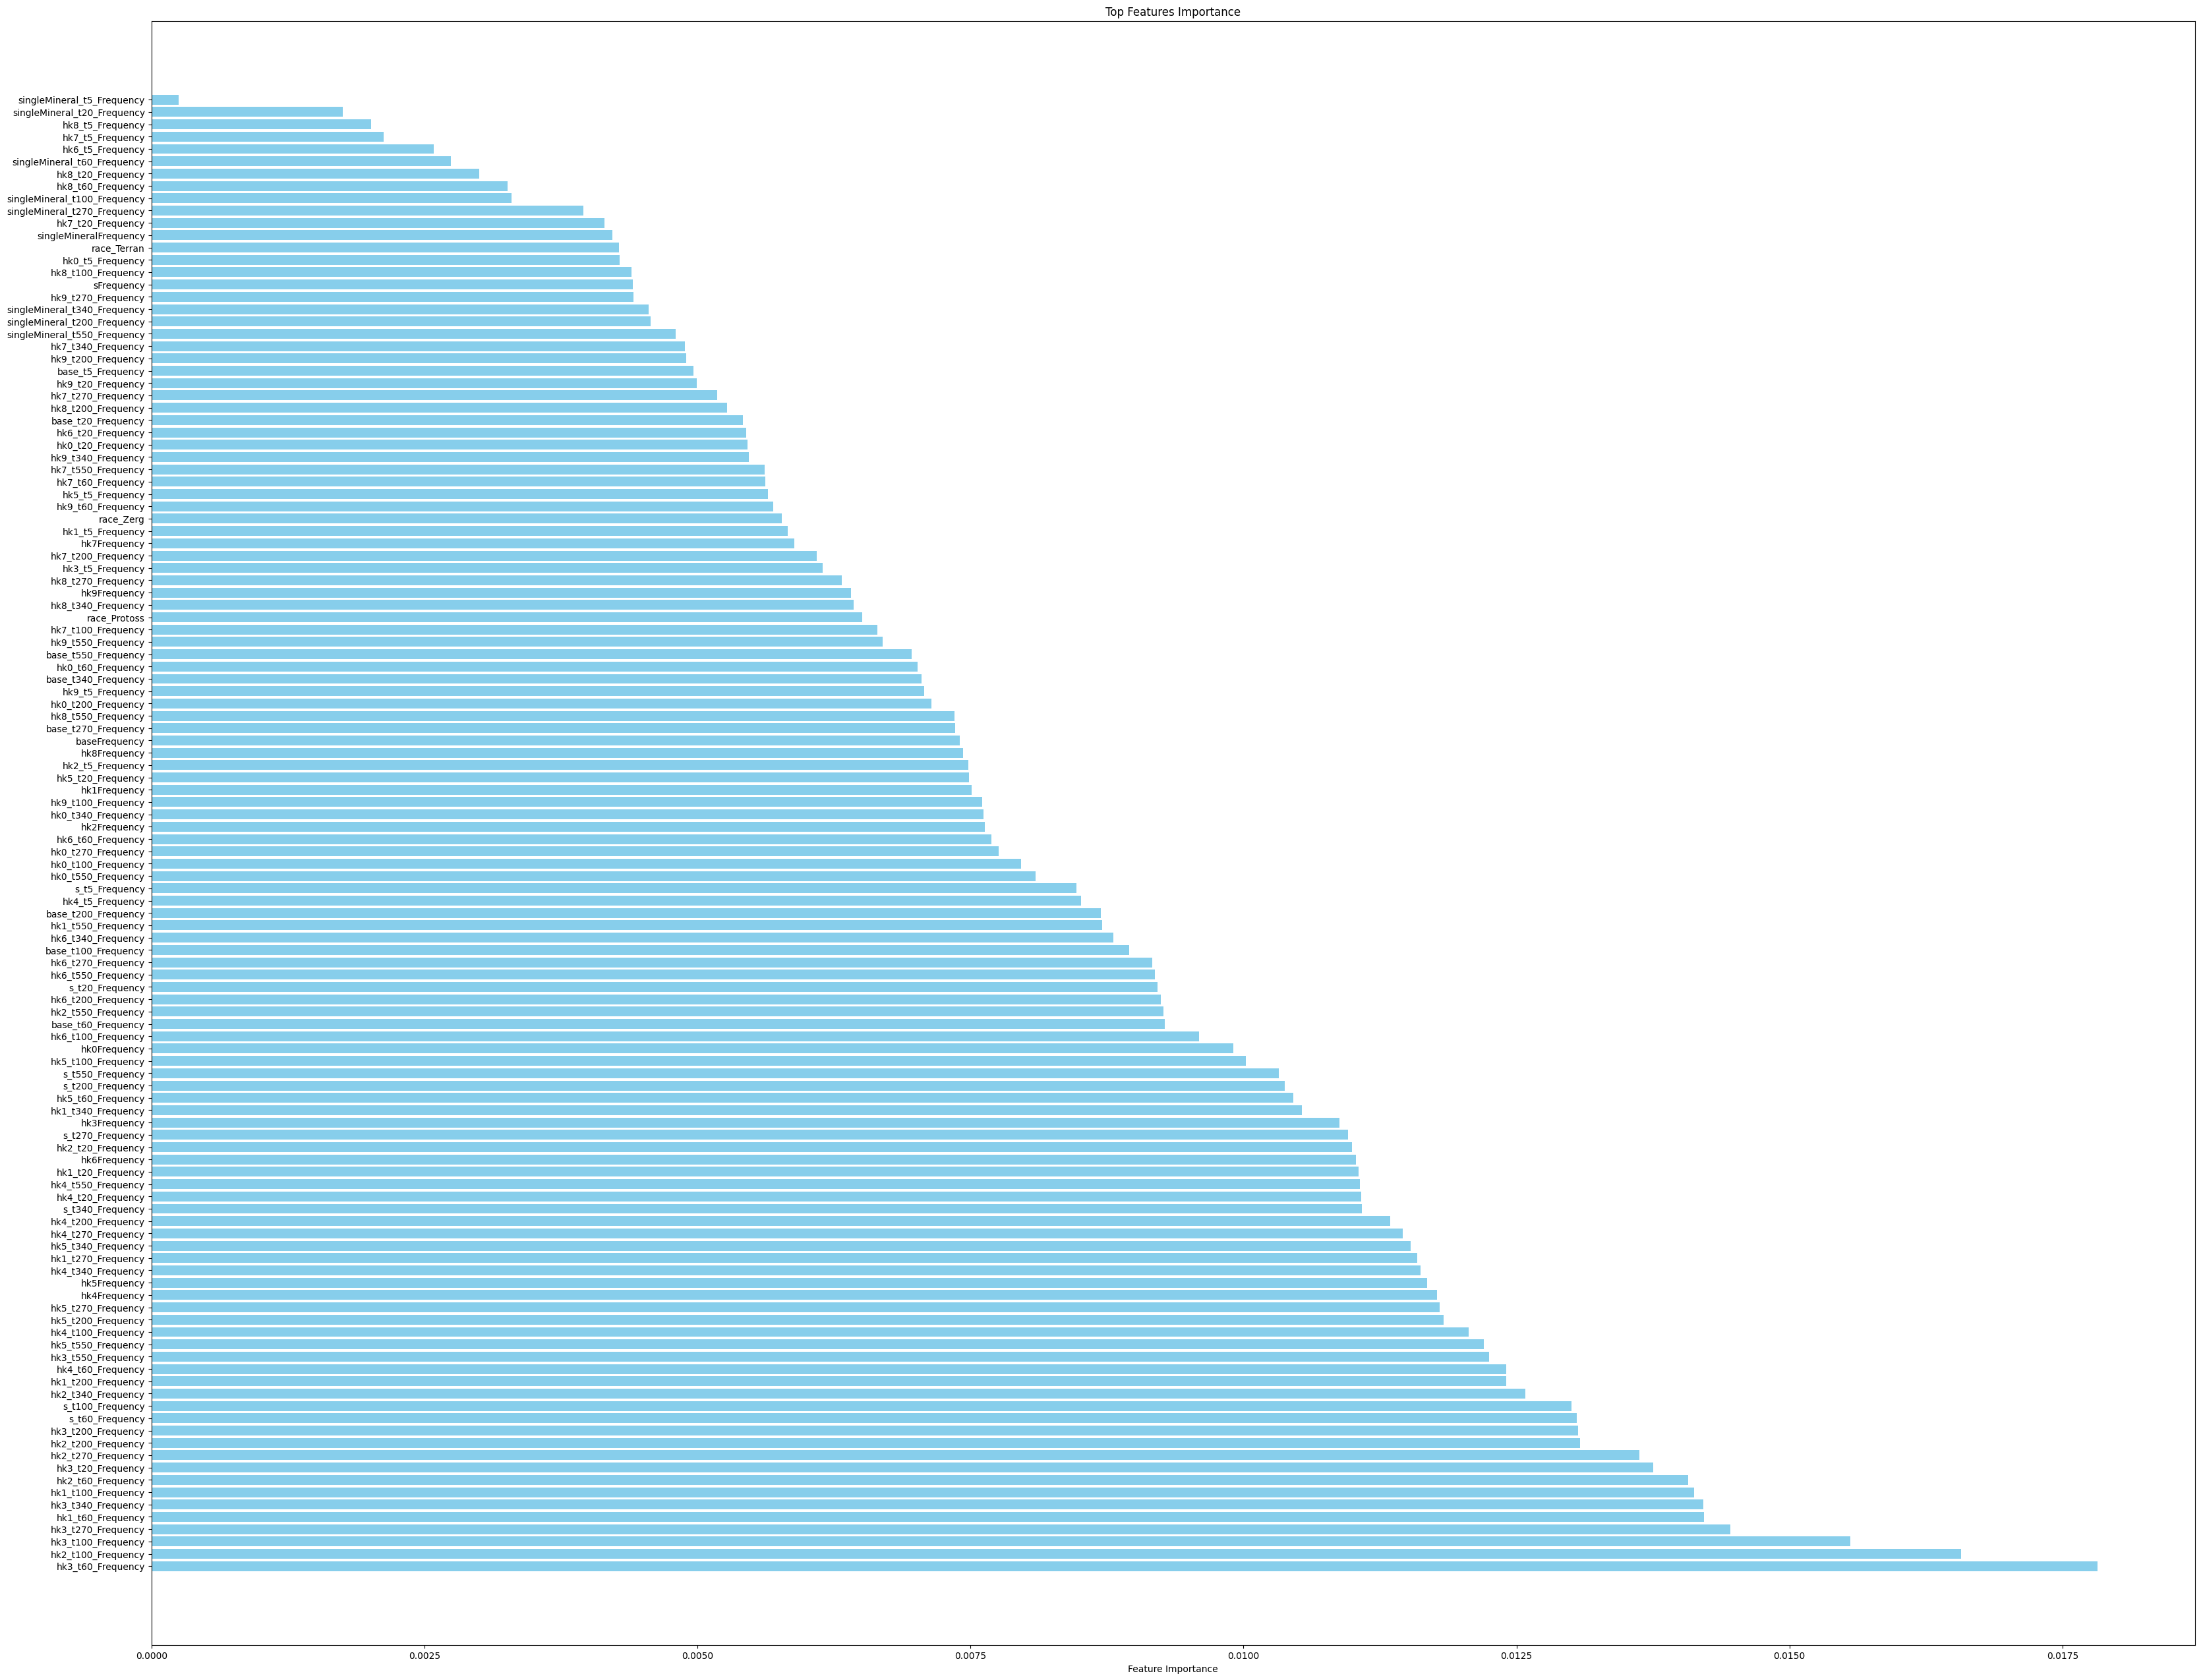

In [15]:
# Plotting the top features
plt.figure(figsize=(40, 32))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top Features Importance')
plt.show()

## Feature Importance for First Prediction

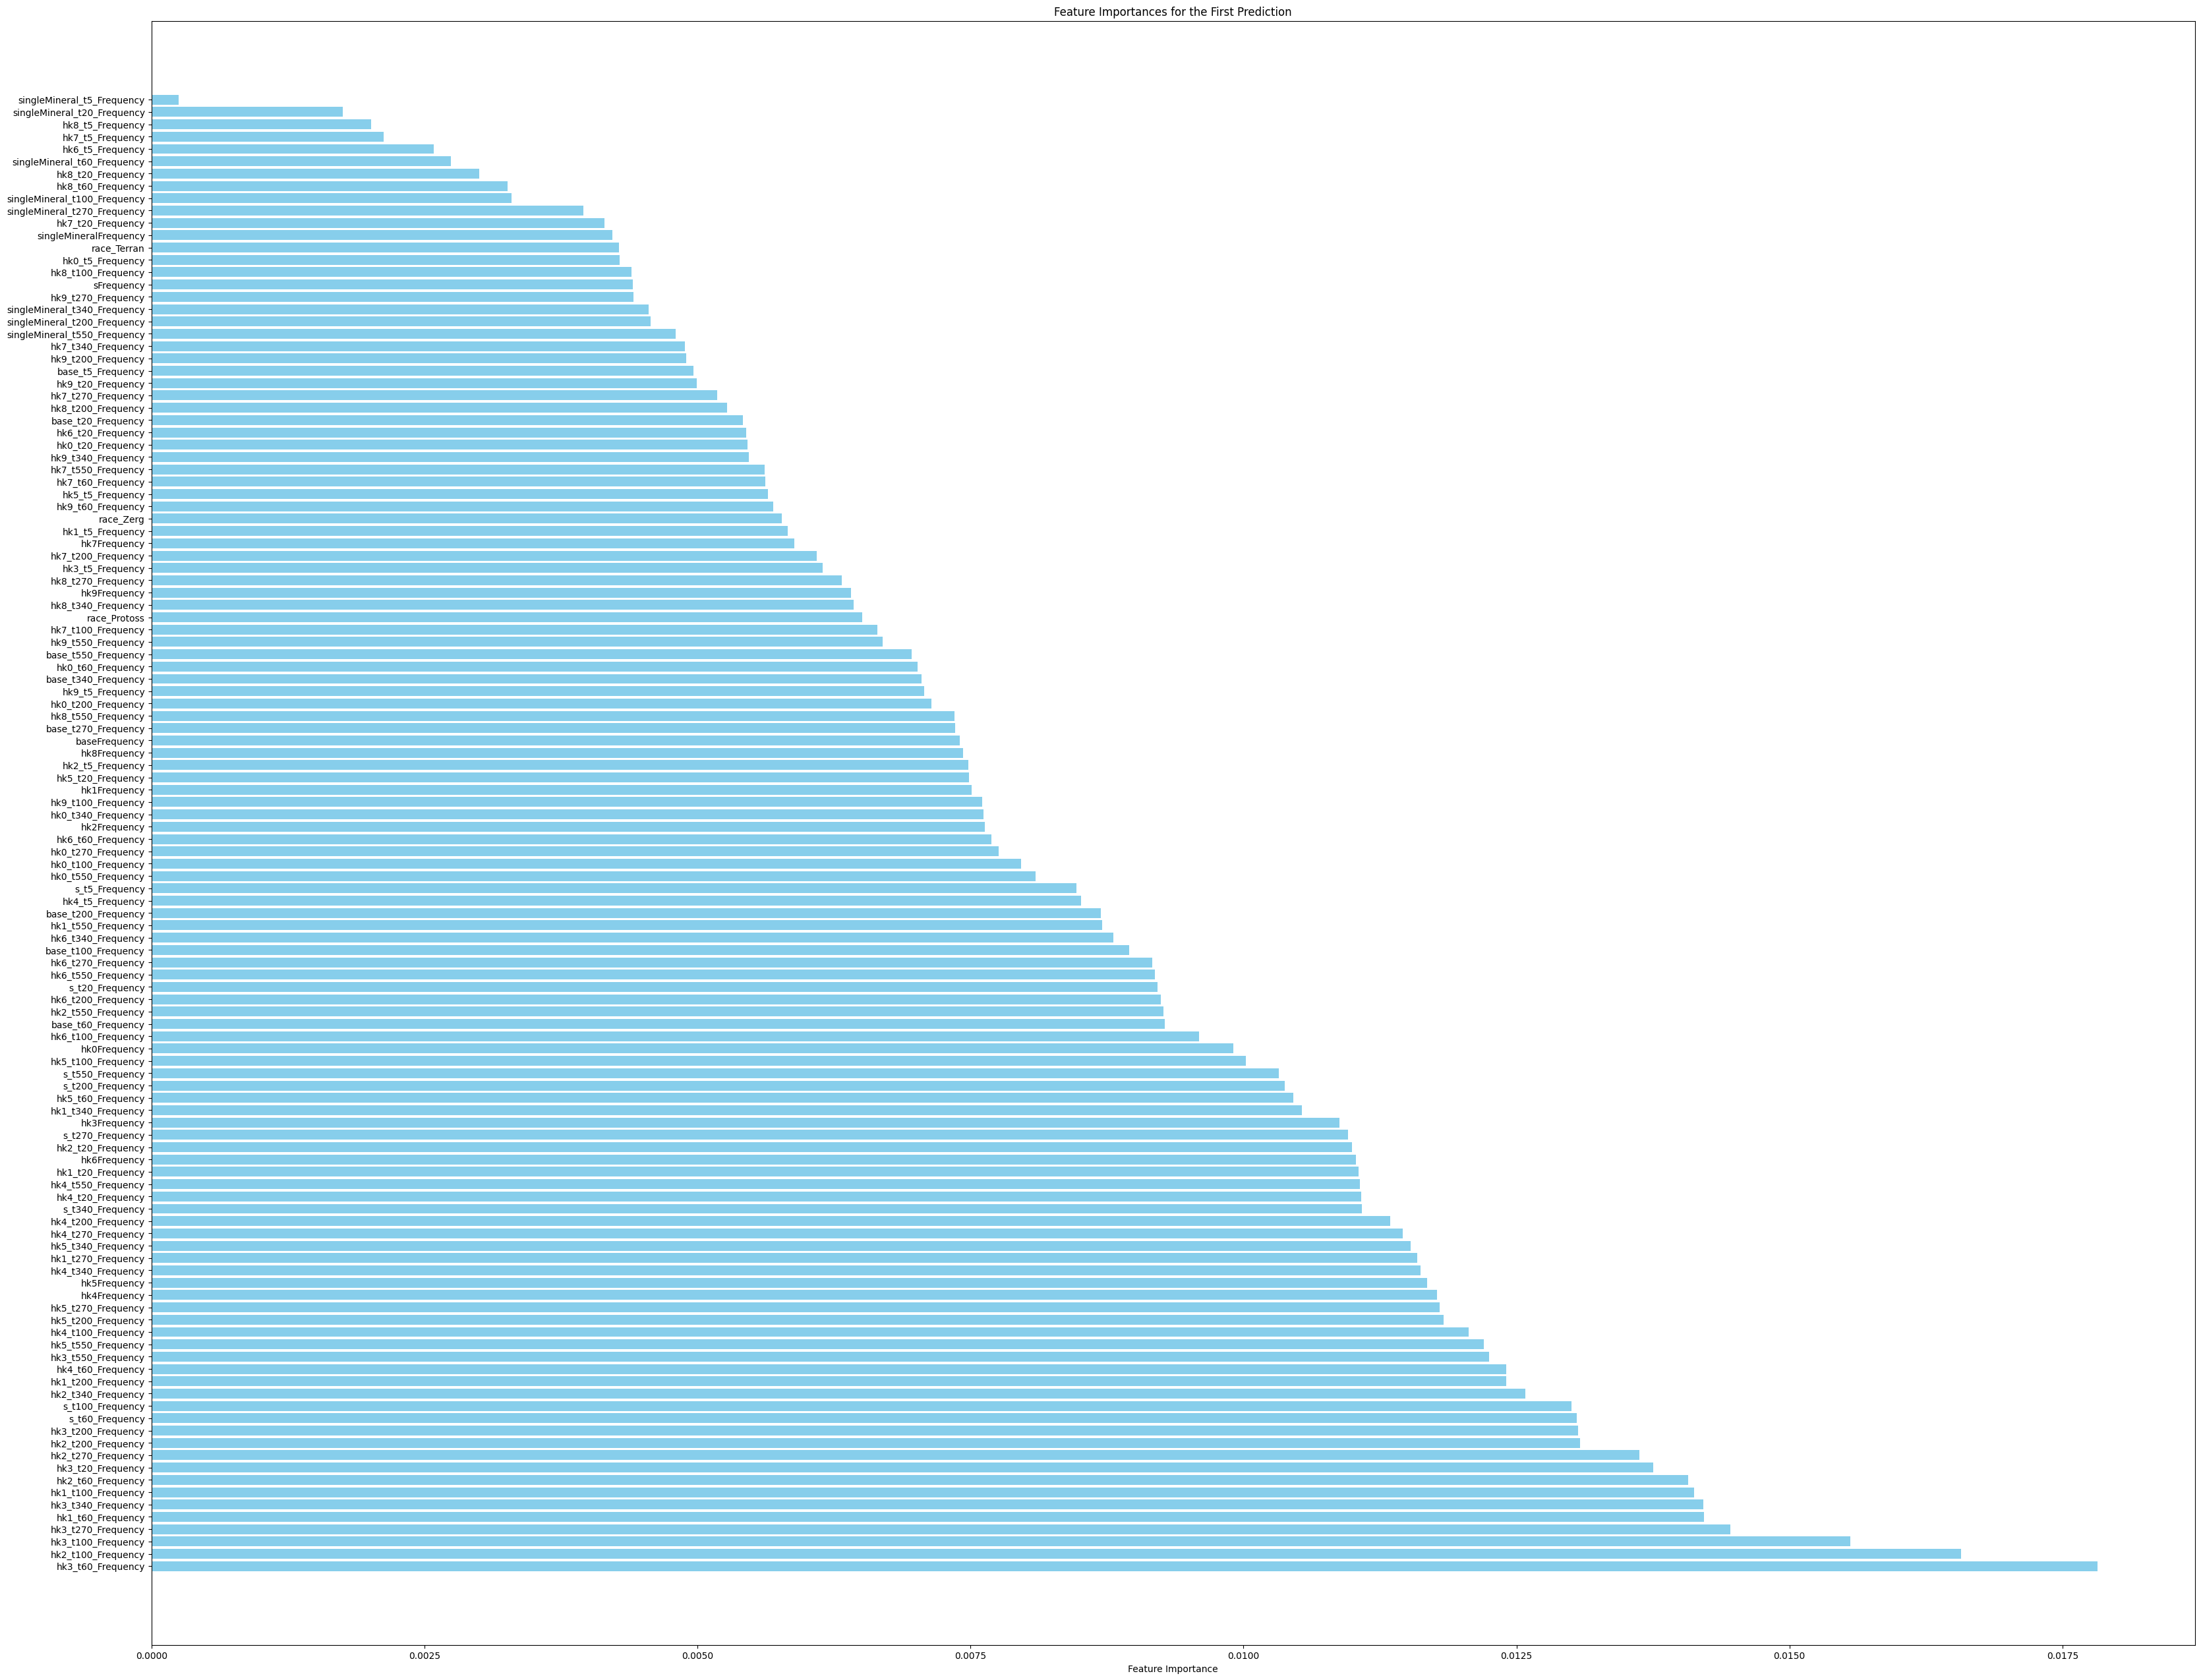

In [16]:
# Plotting
plt.figure(figsize=(40, 32))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances for the First Prediction')
plt.show()

## Least important 30% of Features

In [17]:
# Calculate the threshold for the 30% least important features
threshold = feature_importance_df['Importance'].quantile(0.3)

# Get the least important features
least_important_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()

# Print the least important features
print("Least Important Features (30%):")
print(least_important_features)

Least Important Features (30%):
['hk1_t5_Frequency', 'race_Zerg', 'hk9_t60_Frequency', 'hk5_t5_Frequency', 'hk7_t60_Frequency', 'hk7_t550_Frequency', 'hk9_t340_Frequency', 'hk0_t20_Frequency', 'hk6_t20_Frequency', 'base_t20_Frequency', 'hk8_t200_Frequency', 'hk7_t270_Frequency', 'hk9_t20_Frequency', 'base_t5_Frequency', 'hk9_t200_Frequency', 'hk7_t340_Frequency', 'singleMineral_t550_Frequency', 'singleMineral_t200_Frequency', 'singleMineral_t340_Frequency', 'hk9_t270_Frequency', 'sFrequency', 'hk8_t100_Frequency', 'hk0_t5_Frequency', 'race_Terran', 'singleMineralFrequency', 'hk7_t20_Frequency', 'singleMineral_t270_Frequency', 'singleMineral_t100_Frequency', 'hk8_t60_Frequency', 'hk8_t20_Frequency', 'singleMineral_t60_Frequency', 'hk6_t5_Frequency', 'hk7_t5_Frequency', 'hk8_t5_Frequency', 'singleMineral_t20_Frequency', 'singleMineral_t5_Frequency']
